In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import cv2
import matplotlib
import copy

In [2]:
def chw2hwc(chw):
    assert 3 == len(chw.shape)
    if isinstance(chw, torch.Tensor):
        hwc = torch.permute(chw, (1, 2, 0))
    elif isinstance(chw, np.ndarray):
        hwc = np.moveaxis(chw, 0, -1)
    return hwc

In [3]:
def colorize(
    value, 
    vmin=None, 
    vmax=None, 
    cmap='turbo_r', 
    invalid_val=-99, 
    invalid_mask=None, 
    background_color=(128, 128, 128, 255), 
    gamma_corrected=False, 
    value_transform=None, 
    vminp=2, 
    vmaxp=95):
    """Converts a depth map to a color image.

    Args:
        value (torch.Tensor, numpy.ndarry): Input depth map. Shape: (H, W) or (1, H, W) or (1, 1, H, W). All singular dimensions are squeezed
        vmin (float, optional): vmin-valued entries are mapped to start color of cmap. If None, value.min() is used. Defaults to None.
        vmax (float, optional):  vmax-valued entries are mapped to end color of cmap. If None, value.max() is used. Defaults to None.
        cmap (str, optional): matplotlib colormap to use. Defaults to 'magma_r'.
        invalid_val (int, optional): Specifies value of invalid pixels that should be colored as 'background_color'. Defaults to -99.
        invalid_mask (numpy.ndarray, optional): Boolean mask for invalid regions. Defaults to None.
        background_color (tuple[int], optional): 4-tuple RGB color to give to invalid pixels. Defaults to (128, 128, 128, 255).
        gamma_corrected (bool, optional): Apply gamma correction to colored image. Defaults to False.
        value_transform (Callable, optional): Apply transform function to valid pixels before coloring. Defaults to None.

    Returns:
        numpy.ndarray, dtype - uint8: Colored depth map. Shape: (H, W, 4)
    """
    if isinstance(value, torch.Tensor):
        value = value.detach().cpu().numpy()

    value = value.squeeze()
    if invalid_mask is None:
        invalid_mask = value == invalid_val
        
    mask = np.logical_not(invalid_mask)

    vmin = np.percentile(value[mask],vminp) if vmin is None else vmin
    vmax = np.percentile(value[mask],vmaxp) if vmax is None else vmax
    
    if vmin != vmax:
        value = (value - vmin) / (vmax - vmin)  # vmin..vmax
    else:
        # Avoid 0-division
        value = value * 0.

    # squeeze last dim if it exists
    # grey out the invalid values
    value[invalid_mask] = np.nan
    cmapper = matplotlib.cm.get_cmap(cmap)
    if value_transform:
        value = value_transform(value)
        # value = value / value.max()
    value = cmapper(value, bytes=True)  # (nxmx4)

    # img = value[:, :, :]
    img = value[...]
    img[invalid_mask] = background_color

    #     return img.transpose((2, 0, 1))
    if gamma_corrected:
        # gamma correction
        img = img / 255
        img = np.power(img, 2.2)
        img = img * 255
        img = img.astype(np.uint8)
    return img

In [4]:
def highlight_target(depth_colored_hwc, mask, alpha=0.8):
    mask_3channel = cv2.merge([mask, mask, mask])
    fg_color = (200, 200, 200)  # Example gray value in BGR format
    fg_overlay = np.full_like(depth_colored_hwc, fg_color, dtype=np.uint8)
    inverse_mask = cv2.bitwise_not(mask)
    highlighted_image = np.where(mask_3channel == 0,
                                 (1 - alpha) * depth_colored_hwc + alpha * fg_overlay,
                                 depth_colored_hwc).astype(np.uint8)
    
    contours, _ = cv2.findContours(mask.astype('uint8'), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    highlighted_image = cv2.drawContours(highlighted_image, contours, -1, (0, 0, 0), 1)
    return highlighted_image

In [5]:
idx = '1460103'
stitch_depth_path = '/ibex/ai/home/liz0l/codes/invisible-stitch/work_dir/infer_doublecheck/{}/stitch_pred_depth.png'.format(idx) # {}_depth.png
stitch_raw_depth_path = '/ibex/ai/home/liz0l/codes/invisible-stitch/work_dir/infer_doublecheck/{}/stitch_raw_depth_estimation.png'.format(idx) # {}_depth.png
stitch_matting_path = '/ibex/ai/home/liz0l/codes/invisible-stitch/work_dir/infer_doublecheck/{}/matting.png'.format(idx) # {}_matting.png
# gt_amodal_mask_path = '/ibex/ai/home/liz0l/codes/depth-fm/data/sam/pix2gestalt_occlusions_release/whole_mask' # {}_whole_mask.png
save_path = '/ibex/ai/home/liz0l/codes/depth-fm/work_dir/saves_2'


/tmp/ipykernel_2485368/3536489849.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapper = matplotlib.cm.get_cmap(cmap)


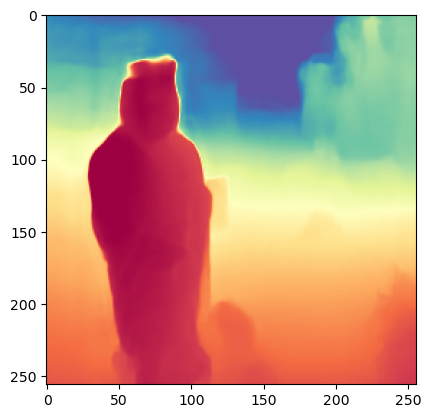

In [6]:
# stitch
stitch_amodal_mask = Image.open(stitch_matting_path).resize((256, 256))
stitch_amodal_mask = np.asarray(stitch_amodal_mask)
stitch_amodal_mask = stitch_amodal_mask

stitch_depth = Image.open(stitch_depth_path).resize((256, 256))
stitch_depth = np.asarray(stitch_depth)

stitch_raw_depth = Image.open(stitch_raw_depth_path).resize((256, 256))
stitch_raw_depth = np.asarray(stitch_raw_depth)
stitch_raw_depth_colored = colorize(stitch_raw_depth, cmap='Spectral')[:, :, :3]
plt.imshow(stitch_raw_depth_colored)



/tmp/ipykernel_2485368/3536489849.py:50: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmapper = matplotlib.cm.get_cmap(cmap)


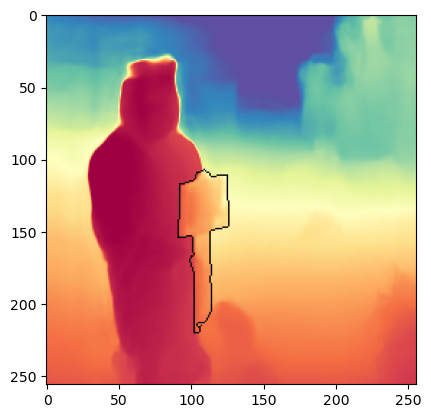

True

In [7]:
stitch_raw_depth_bg = copy.deepcopy(stitch_raw_depth)
stitch_raw_depth_bg[stitch_amodal_mask > 0] = stitch_depth[stitch_amodal_mask > 0]
stitch_raw_depth_depth_agg = copy.deepcopy(stitch_raw_depth_bg)

stitch_depth_colored = colorize(stitch_raw_depth_depth_agg, cmap='Spectral')[:, :, :3]
stitch_depth_colored_highlited = highlight_target(stitch_depth_colored, stitch_amodal_mask, alpha=0.0)
plt.imshow(stitch_depth_colored_highlited)
plt.show()
cv2.imwrite(os.path.join(save_path, '{}_stitch.png'.format(id)), stitch_depth_colored_highlited[:, :, [2, 1, 0]])